<a href="https://colab.research.google.com/github/BooBoa/Stable_diffusion-dreamlikediffusion/blob/main/Stable_diffusion_booboa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Run This Cell first: will install all requirements.
!pip install "ipywidgets>=7,<8"
%pip install --quiet --upgrade diffusers transformers scipy mediapy accelerate ftfy spacy
import subprocess
# The xformers package is mandatory to be able to create several 768x768 images.
github_url = "https://github.com/brian6091/xformers-wheels"
xformer_id = "0.0.15.dev0+4c06c79"
xformers_wheels = f"xformers-{xformer_id}.d20221205-cp38-cp38-linux_x86_64.whl"
# Install xformers using pre-compiled Python wheels
%pip install -q {github_url}/releases/download/{xformer_id}/{xformers_wheels}

In [ ]:
#@title Log Into Hugging face
from google.colab import output
output.enable_custom_widget_manager()

from huggingface_hub import notebook_login
notebook_login()


## Model's

* dreamlike-art/dreamlike-photoreal-2.0 https://huggingface.co/dreamlike-art/dreamlike-photoreal-2.0 
* dreamlike-art/dreamlike-diffusion-1.0  https://huggingface.co/dreamlike-art/dreamlike-diffusion-1.0
* stabilityai/stable-diffusion-2-1 https://huggingface.co/stabilityai/stable-diffusion-2-1
* Linaqruf/anything-v3.0  For the Weebs! Brilliant anime model!  https://huggingface.co/Linaqruf/anything-v3.0

## Scheduler's

* DPMMultistep = DPMSolverMultistepScheduler
* DDIM = DDIMScheduler
* EADS = EulerAncestralDiscreteScheduler
* KDPM2 = KDPM2AncestralDiscreteScheduler

Documentation can be found here https://huggingface.co/docs/diffusers/api/schedulers/overview


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

997272570271343


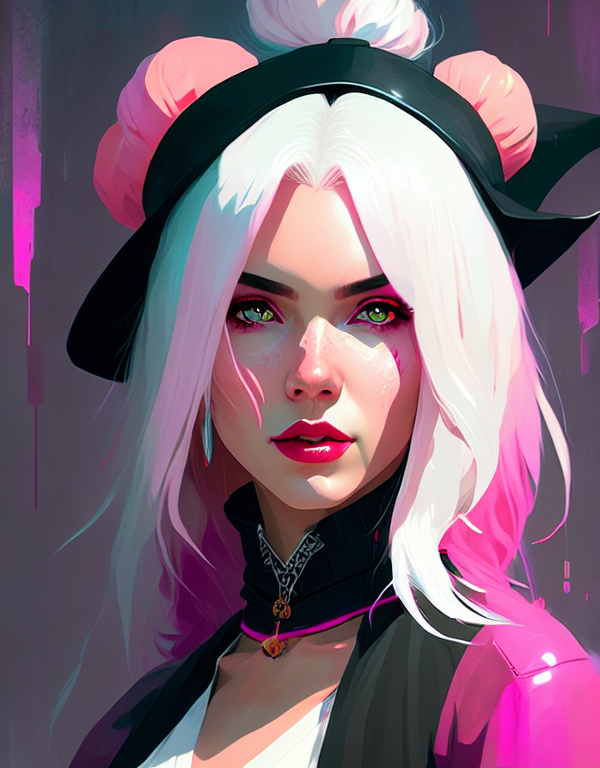

  0%|          | 0/30 [00:00<?, ?it/s]

7750787975617429


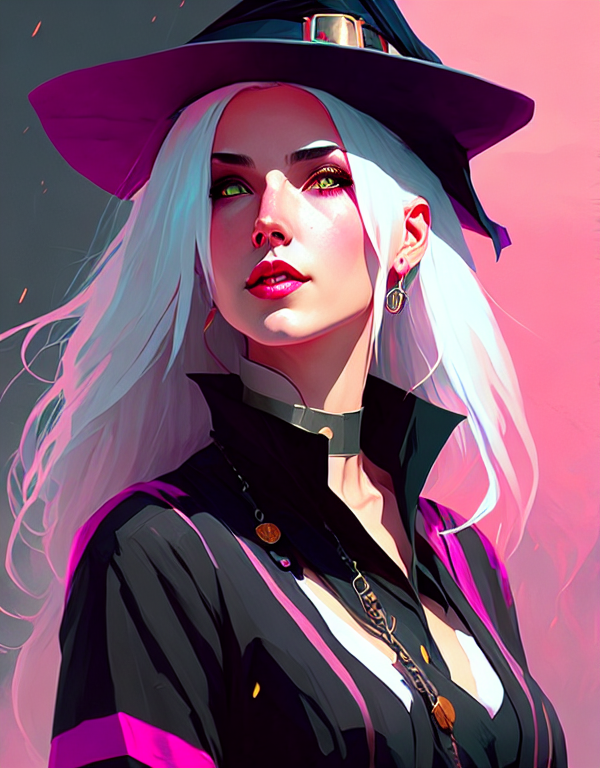

  0%|          | 0/30 [00:00<?, ?it/s]

1103283260854658


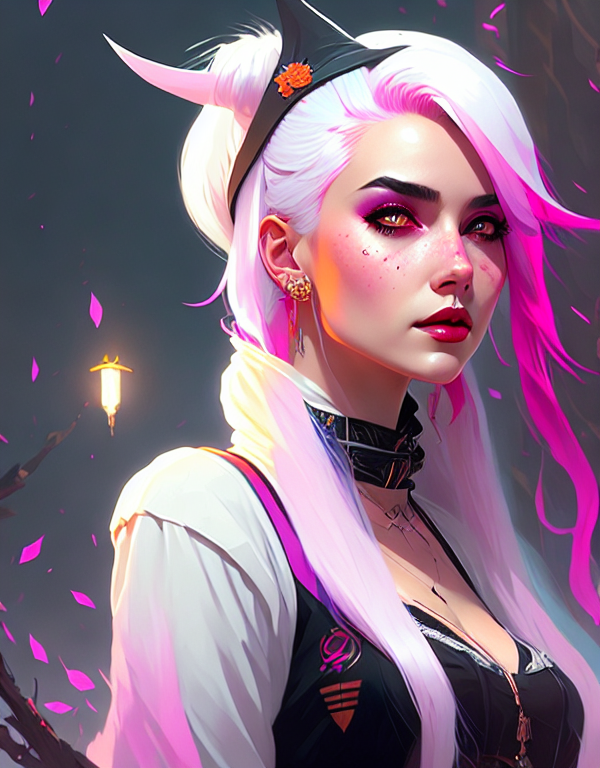

In [123]:
#@title #Generate Images
from torch.utils.data.dataset import Generator
from PIL import Image
from transformers import image_utils
from diffusers.pipelines.stable_diffusion import safety_checker
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler, KDPM2AncestralDiscreteScheduler
from IPython.display import display

# Device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Model's to add new models place model's name from huggingface inside the square brackets
model_id = "dreamlike-art/dreamlike-diffusion-1.0" #@param ["dreamlike-art/dreamlike-diffusion-1.0","stabilityai/stable-diffusion-2-1", "Linaqruf/anything-v3.0", "dreamlike-art/dreamlike-photoreal-2.0"] 

# Shedulers
DPMMultistep = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
DDIM = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
EADS = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
KDPM2 = KDPM2AncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")

# Parameters
scheduler = DPMMultistep #@param ["DPMMultistep", "DDIM", "EADS", "KDPM2"] {type:"raw"}
prompt = "dreamlikeart, pretty female witch. white and pink hair , by atey ghailan, by greg rutkowski, grunge aesthetic" #@param {type:"string"}
negative_prompt = "ugly, morbid, extra fingers, poorly drawn hands , mutation , blurry, extra limbs, gross proportions , missing arms, mutated hands, long neck, duplicate, mutilated , mutilated hands, poorly drawn face, deformed, bad anatomy, cloned face , malformed limbs, missing legs, too many fingers" #@param {type:"string"}
height = 768  #@param {type: "slider", min:64, max:1280, step:8}
width = 600 #@param {type: "slider", min:64, max:1280, step:8}
guidance_scale = 8 #@param {type: "slider", min:1, max:20, step:0.1}
num_inference_steps = 30 #@param {type: "slider", min:10, max:500, step:1}
num_images = 3 #@param {type: "number"}

# Pipe function
def pipe(model_id,
         schedular,
         safety_checker=None
         ):
  pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                          scheduler=scheduler,
                                          safety_checker=None,
                                          torch_dtype=torch.float16).to("cuda")
  pipe.enable_attention_slicing()
  pipe.enable_xformers_memory_efficient_attention()
  return pipe

# Generate seeds then images
def gen_images(pipe):  
  for i in range(num_images):
    random_seed = True #@param{type: "boolean"}
    if random_seed == True:
      # Generate random seed's
      generator = torch.Generator(device=DEVICE)
      seed = generator.seed()
      generator = generator.manual_seed(seed)
    else:
      # Fix seed for reproducibility
      seed = 3628107734277603 #@param{type:"number"}
      generator = torch.Generator(device=DEVICE)
      generator = generator.manual_seed(seed)
      # Generate images
    with autocast(DEVICE), torch.inference_mode():
      images = pipe(
                  prompt=prompt,
                  negative_prompt=negative_prompt,
                  height=height,
                  width=width,
                  num_inference_steps=num_inference_steps,
                  guidance_scale=guidance_scale,
                  generator=generator
                  ).images
    # Our images will save under the name of the seed it was produced with
    # When fine tuning prompts on a particuler seed the save function will overwrite
    # Save your best image under a different name
    for img in images:
      img.save(f"Seed_{seed}.png")
      print(seed)
      display(img)
      
def start_inference():
  
  gen_images(pipe(model_id,
                  scheduler))
  
start_inference()